# Mackey-Glass autoregression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import water_tank as wt

In [2]:
N_in = 1 # number of inputs
N_out = 1 # number of outputs
N = 200 # number of neurons
g = 1.25 # scaling factor
tau = 3.3 # time constant
sparseness = 0.1 # sparseness of the recurrent weights

In [3]:
class RC(object):

    def __init__(self, N, N_in, N_out, g, tau, sparseness):

        # Input population
        self.inp = wt.StaticInput(size=N_in)

        # Reservoir 
        self.rc = wt.Reservoir(size=N, tau=tau)

        # Readout
        self.readout = wt.LinearReadout(size=N_out)

        # Input projection
        self.inp_proj = wt.connect(
            pre=self.inp, 
            post=self.rc, 
            weights=wt.Bernouilli([-1.0, 1.0], p=0.5), 
            bias=wt.Bernouilli([-1.0, 1.0], p=0.5), # very important
            sparseness=0.1
        )

        # Recurrent projection
        self.rec_proj = wt.connect(
            pre=self.rc, 
            post=self.rc, 
            weights=wt.Normal(0.0, g/np.sqrt(sparseness*N)), 
            bias=None,
            sparseness=sparseness)

        # Readout projection
        self.readout_proj = wt.connect(
            pre = self.rc, 
            post = self.readout,
            weights = wt.Uniform(-0.01, 0.01), # very small but not zero
            bias=wt.Const(0.0), # learnable bias
            sparseness=1.0 # readout should be dense
        )

        # Feedback projection
        #self.feedback_proj = wt.connect(self.readout, self.rc, wt.Uniform(-1.0, 1.0))

        # Learning rules
        #self.learningrule = wt.DeltaLearningRule(projection=self.readout_proj, learning_rate=0.01)
        self.learningrule = wt.RLS(projection=self.readout_proj, delta=1e-6)

        # Recorder
        self.recorder = wt.Recorder()

    @wt.measure
    def train(self, X, Y, warmup=0):

        for t, (x, y) in enumerate(zip(X, Y)): 

            # Inputs/targets
            self.inp.set(x)

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Learning
            if t >= warmup: self.learningrule.step(target=y)

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output(),
            })
    
    @wt.measure
    def autoregressive(self, duration):

        for _ in range(duration): 
            # Autoregressive input
            self.inp.set(self.readout.output())  

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output()
            })

In [4]:
from reservoirpy.datasets import mackey_glass

# Mackey-Glass chaotic time series
T = 2000
mg = mackey_glass(T)
mg =  2.0 * (mg - mg.min()) / (mg.max() - mg.min()) - 1.0
X = mg[:-1, 0]
Y = mg[1:, 0]

In [5]:
net = RC(N, N_in, N_out, g, tau, sparseness)

# Training / test
d_train = 500
d_test = 1000

# Supervised training
net.train(X[:d_train], Y[:d_train], warmup=0)
data_train = net.recorder.get()

# Autoregressive test
net.autoregressive(duration=d_test)
data_test = net.recorder.get()

Execution time: 716 ms
Execution time: 27 ms


/var/folders/6w/6msx49ws7k13cc0bbys0tt4m0000gn/T/ipykernel_33855/2895089909.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


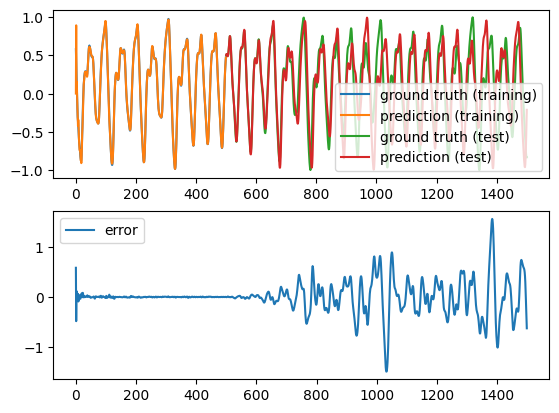

In [6]:
plt.figure()
plt.title("Autoregression")
plt.subplot(211)
plt.plot(Y[:d_train], label='ground truth (training)')
plt.plot(data_train['readout'][:, 0], label='prediction (training)')
plt.plot(np.linspace(d_train, d_train+d_test, d_test), Y[d_train:d_train+d_test], label='ground truth (test)')
plt.plot(np.linspace(d_train, d_train+d_test, d_test), data_test['readout'][:, 0], label='prediction (test)')
plt.legend()
plt.subplot(212)
plt.plot(Y[:d_train+d_test] - np.concatenate((data_train['readout'][:, 0], data_test['readout'][:, 0])), label='error')
plt.legend()

plt.show()